Команда внедрила в приложение по доставке продуктов новую умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Необходимо:
- оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения,
- предоставить аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.

Данные:

- ab_users_data – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи
- ab_orders – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ
- ab_products – подробная информация о продуктах, их название и стоимость

In [1]:
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#сначала загрузим данные и посмотрим на них
ab_orders = pd.read_csv('ab_orders.csv')
ab_products = pd.read_csv('ab_products.csv')
ab_users_data = pd.read_csv('ab_users_data.csv')

In [3]:
ab_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [4]:
ab_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   order_id       4123 non-null   int64 
 1   creation_time  4123 non-null   object
 2   product_ids    4123 non-null   object
dtypes: int64(1), object(2)
memory usage: 96.8+ KB


In [5]:
ab_products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [6]:
ab_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  87 non-null     int64  
 1   name        87 non-null     object 
 2   price       87 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB


In [7]:
ab_users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [8]:
ab_users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   4337 non-null   int64 
 1   order_id  4337 non-null   int64 
 2   action    4337 non-null   object
 3   time      4337 non-null   object
 4   date      4337 non-null   object
 5   group     4337 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 203.4+ KB


In [9]:
#в таблице ab_orders данные в столбце product_ids не очень удобны для анализа количества заказанных продуктов
#преобразуем данные так, чтобы каждый продукт из заказа пользователя был на отдельной строке

ab_orders['product_ids'] = ab_orders.product_ids.str.strip('{}').str.split(',')
ab_orders = ab_orders.explode('product_ids')
ab_orders['product_ids'] = ab_orders['product_ids'].astype(str).astype(int)
ab_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,75
0,1255,2022-08-26 00:00:19.000000,22
0,1255,2022-08-26 00:00:19.000000,53
0,1255,2022-08-26 00:00:19.000000,84
1,1256,2022-08-26 00:02:21.000000,56


In [10]:
#смерджим все 3 датафрейма
ab_full = pd.merge(pd.merge(ab_orders, ab_products, 
                  left_on='product_ids', right_on='product_id', 
                  how='left'), ab_users_data, on='order_id', how='left')

In [11]:
ab_full.head()
#теперь удалим один из столбцов, по которым мерджили, удалим все отмененные заказы
#проверим, дублируется ли информация в столбцах creation_time и time (и если да, то тоже удалим один из столбцов)
#работать будем только с неотмененными заказами, поэтому удалим записи об отмене заказа и о создании впоследствии отмененного заказа

,order_id,creation_time,product_ids,product_id,name,price,user_id,action,time,date,group
0,1255,2022-08-26 00:00:19.000000,75,75,сок ананасовый,120.0,964,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,1255,2022-08-26 00:00:19.000000,22,22,сок мультифрукт,120.0,964,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
2,1255,2022-08-26 00:00:19.000000,53,53,мука,78.3,964,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
3,1255,2022-08-26 00:00:19.000000,84,84,мандарины,90.4,964,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
4,1256,2022-08-26 00:02:21.000000,56,56,сосиски,150.0,965,create_order,2022-08-26 00:02:21.000000,2022-08-26,1


In [12]:
#удалим столбец product_ids
ab_full = ab_full.drop(columns=['product_ids'])

In [13]:
#добавим столбец для сравнения столбцов creation_time и time
comparison_column = np.where(ab_full["creation_time"] == ab_full["time"], True, False)
ab_full["equal"] = comparison_column
#посмотрим, какие значения есть
ab_full.equal.value_counts()

True     13826
False      743
Name: equal, dtype: int64

In [14]:
#есть 743 записи, у которых creation_time и time не совпадают - проверим, что это за действия
ab_full.query('equal == False').action.value_counts()

cancel_order    743
Name: action, dtype: int64

In [15]:
#это все отмены заказов - отлично, мы как раз собираемся рабоать только с неотмененными заказами
#удалим столбцы creation_time и equal
ab_full = ab_full.drop(columns=['creation_time', 'equal'])
ab_full.head()

,order_id,product_id,name,price,user_id,action,time,date,group
0,1255,75,сок ананасовый,120.0,964,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,1255,22,сок мультифрукт,120.0,964,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
2,1255,53,мука,78.3,964,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
3,1255,84,мандарины,90.4,964,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
4,1256,56,сосиски,150.0,965,create_order,2022-08-26 00:02:21.000000,2022-08-26,1


In [16]:
#посмотрим еще раз, сколько раз создавали заказы и сколько раз отменяли
ab_full.action.value_counts()
#743 отмененных заказа, то есть после их удаления у нас должно остаться 13083 строки - можно себя проверить

create_order    13826
cancel_order      743
Name: action, dtype: int64

In [17]:
order_id_cancelled = ab_full.query('action == "cancel_order"').order_id
ab_full_success = ab_full.query("order_id not in @order_id_cancelled")
ab_full_success.action.value_counts()

create_order    13083
Name: action, dtype: int64

In [18]:
ab_full_success.info()
#13083 строки - все верно

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13083 entries, 0 to 14568
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order_id    13083 non-null  int64  
 1   product_id  13083 non-null  int64  
 2   name        13083 non-null  object 
 3   price       13083 non-null  float64
 4   user_id     13083 non-null  int64  
 5   action      13083 non-null  object 
 6   time        13083 non-null  object 
 7   date        13083 non-null  object 
 8   group       13083 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 1022.1+ KB


In [19]:
#теперь над общий датафрейм выглядит так
ab_full_success.head()

,order_id,product_id,name,price,user_id,action,time,date,group
0,1255,75,сок ананасовый,120.0,964,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,1255,22,сок мультифрукт,120.0,964,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
2,1255,53,мука,78.3,964,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
3,1255,84,мандарины,90.4,964,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
4,1256,56,сосиски,150.0,965,create_order,2022-08-26 00:02:21.000000,2022-08-26,1


# Определяем целевые метрики, на которые могла повлиять новая система рекомендаций.

Будем смотреть только неотмененные заказы.

- среднее количество товаров в заказе в группах
- средняя сумма чека всех заказов в группах
- общая выручка
- среднее количество заказов на пользователя в группах

# Среднее количество товаров в заказе

In [20]:
#первая метрика
avg_amount_of_prod_in_order = ab_full_success.groupby(['group', 'order_id']) \
    .agg({'product_id': 'count'}) \
    .rename(columns={'product_id': 'amount'}) \
    .reset_index()
avg_amount_of_prod_in_order.groupby('group').agg({'amount': 'mean'}).round(2).rename(columns={'amount': 'avg_amount'})

,avg_amount
group,
0,3.34
1,3.35


Среднее количество товаров за одну покупку, кажется, сильно не изменилось, но необходимо это проверить.

Проведем выбор теста и формулирование гипотез.

- H0 - cреднее количество товаров в заказах не изменилось
- H1 - cреднее количество товаров в заказах изменилось

Две группы и дискретная  величина - будем использовать t-тест, только нужно проверить распределение на нормальность и гомоскедастичность.

In [21]:
avg_amount_of_prod_in_order.head()

,group,order_id,amount
0,0,1255,4
1,0,1257,4
2,0,1261,4
3,0,1262,4
4,0,1265,5


In [22]:
avg_amount_of_prod_in_order_0 = avg_amount_of_prod_in_order.query('group == 0').amount
avg_amount_of_prod_in_order_1 = avg_amount_of_prod_in_order.query('group == 1').amount

Посмотрим на распределения на графиках и проверим с помощью теста на нормальность.

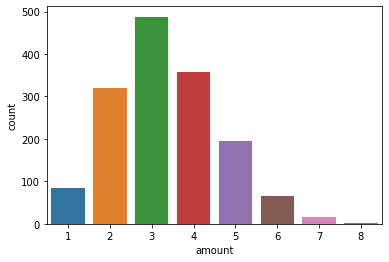

In [23]:
sns.countplot(x=avg_amount_of_prod_in_order_0)

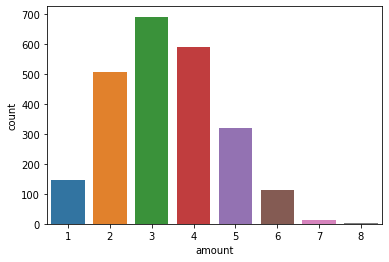

In [24]:
sns.countplot(x=avg_amount_of_prod_in_order_1)

In [25]:
#нормальность распределения
statistic_0, pvalue_0 = ss.normaltest(avg_amount_of_prod_in_order_0)
statistic_1, pvalue_1 = ss.normaltest(avg_amount_of_prod_in_order_1)
print(f'Значения p-value распределения группы 0 - {pvalue_0}, группы 1 - {pvalue_1}.')

Значения p-value распределения группы 0 - 1.3190671330026563e-08, группы 1 - 6.85442961037773e-10.


Оба значения < 0.05, а значит распределения не являются нормальными.

Посмотрим, есть ли какие-то выбросы в распределениях.

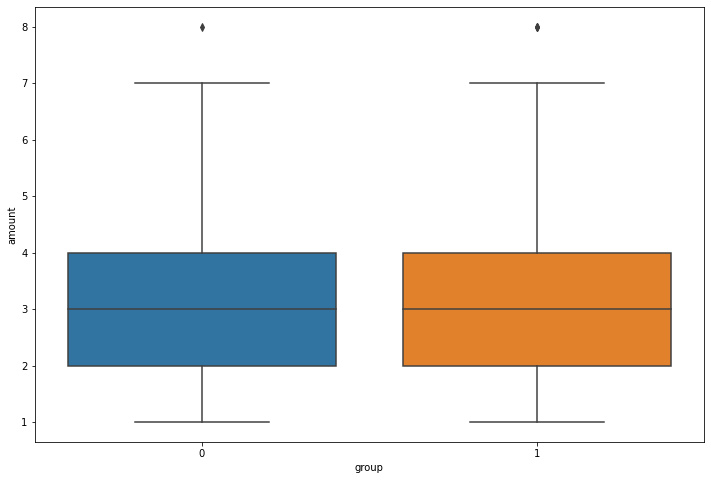

In [26]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='group', y='amount', data=avg_amount_of_prod_in_order)

Сильных выбросов не наблюдается.

Проверим на гомоскедастичность.

In [27]:
ss.levene(avg_amount_of_prod_in_order_0, avg_amount_of_prod_in_order_1)

LeveneResult(statistic=1.787947798610625, pvalue=0.18125424676983376)

Гомоскедастичность - ок.

Воспользуемся t-тестом.

In [28]:
ss.ttest_ind(avg_amount_of_prod_in_order_0, avg_amount_of_prod_in_order_1)

Ttest_indResult(statistic=-0.19638057741712578, pvalue=0.84432251088501)

p-value > 0.05, а значит, мы не можем отклонить нулевую гипотезу. Впрочем этот результат мы и ожидали.

Вывод делать пока рано - исследуем остальные метрики.

# Средний чек

In [29]:
#вторая метрика
avg_sum_by_order = ab_full_success.groupby(['group', 'order_id']) \
    .agg({'price': 'sum'}) \
    .reset_index()
avg_sum_by_order.groupby('group').agg({'price': 'mean'}).round(2).rename(columns={'price': 'avg_price'})

,avg_price
group,
0,382.09
1,368.86


На первый взгляд средний чек изменился (причем стал меньше) - надо проверить. 

Сформулируем гипотезы:

- H0 - средний чек не изменился
- H1 - средний чек изменился

Две группы и дискретная величина - будем использовать t-тест, только нужно проверить распределение на нормальность и гомоскедастичность.

In [30]:
avg_sum_by_order.head()

,group,order_id,price
0,0,1255,408.7
1,0,1257,310.2
2,0,1261,430.7
3,0,1262,358.6
4,0,1265,546.4


In [31]:
avg_sum_by_order_0 = avg_sum_by_order.query('group == 0').price
avg_sum_by_order_1 = avg_sum_by_order.query('group == 1').price

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


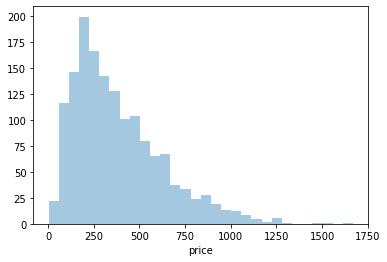

In [32]:
sns.distplot(avg_sum_by_order_0, hist=True, kde=False)

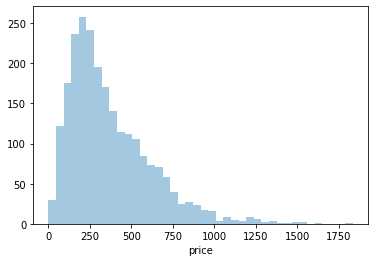

In [33]:
sns.distplot(avg_sum_by_order_1, hist=True, kde=False)

Видим, что, во-первых, распределения не являются нормальными, а во-вторых, очень похожи. Убедимся в этом:

In [34]:
statistic_2, pvalue_2 = ss.normaltest(avg_sum_by_order_0)
statistic_3, pvalue_3 = ss.normaltest(avg_sum_by_order_1)
print(f'Значения p-value распределения группы 0 - {pvalue_2}, группы 1 - {pvalue_3}.')

Значения p-value распределения группы 0 - 1.1447851440676955e-60, группы 1 - 3.5147660678462184e-128.


Оба значения менее 0.05 - распределения не являются нормальными.

In [35]:
ss.levene(avg_sum_by_order_0, avg_sum_by_order_1)

LeveneResult(statistic=1.0117862321327593, pvalue=0.31453758452176295)

Гомоскедастичность - ок.

Воспользуемся t-тестом.

In [36]:
ss.ttest_ind(avg_sum_by_order_0, avg_sum_by_order_1)

Ttest_indResult(statistic=1.6334875192269402, pvalue=0.10244707728234669)

p-value сильно больше 0.05, значит, и здесь нулевую гипотезу отклонить мы не можем, и разница между средними чеками за заказ в двух группах не является статистически значимой.

Проверим общую выручку.

# Общая выручка

In [37]:
#третья метрика
total_sum = ab_full_success.groupby(['group', 'order_id']) \
    .agg({'price': 'sum'}) \
    .reset_index()
total_sum.groupby('group').agg({'price': 'sum'}).round(2).rename(columns={'price': 'total'})

,total
group,
0,583455.9
1,878628.4


Общая выручка точно изменилась - и в тестовой группе она оказалась гораздо выше.

# Среднее количество заказов на пользователя

In [38]:
#четвертая метрика
avg_amount_of_orders_by_user = ab_full_success.groupby(['group', 'user_id']) \
    .order_id.nunique() \
    .reset_index() \
    .sort_values('order_id', ascending=False) \
    .rename(columns={'order_id': 'amount_of_orders'})
avg_amount_of_orders_by_user.groupby('group').agg({'amount_of_orders': 'mean'}).rename(columns={'amount_of_orders': 'avg_amount_of_orders'})

,avg_amount_of_orders
group,
0,2.982422
1,4.754491


Сформулируем гипотезы:

- H0 - среднее количество заказов на пользователя не изменилось
- H1 - среднее количество заказов на пользователя изменилось

Две группы и дискретная величина - будем использовать t-тест, только нужно проверить распределение на нормальность и гомоскедастичность.

In [39]:
avg_amount_of_orders_by_user.head()

,group,user_id,amount_of_orders
99,0,1170,13
821,1,1583,12
793,1,1537,12
650,1,1240,11
279,0,1514,11


Сделаем все то же самое, что делали с предыдущими метриками. Проверим распределения на нормальность и гомоскедастичность.

In [40]:
avg_amount_of_orders_by_user_0 = avg_amount_of_orders_by_user.query('group == 0').amount_of_orders
avg_amount_of_orders_by_user_1 = avg_amount_of_orders_by_user.query('group == 1').amount_of_orders

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


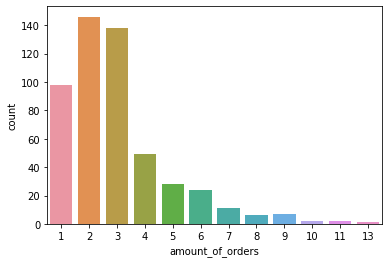

In [41]:
sns.countplot(avg_amount_of_orders_by_user_0)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


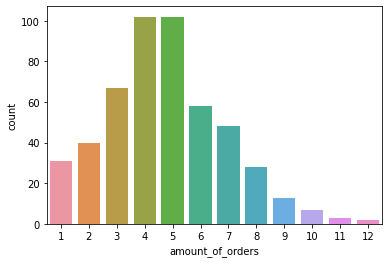

In [42]:
sns.countplot(avg_amount_of_orders_by_user_1)

In [43]:
#нормальность
statistic_4, pvalue_4 = ss.normaltest(avg_amount_of_orders_by_user_0)
statistic_5, pvalue_5 = ss.normaltest(avg_amount_of_orders_by_user_1)
print(f'Значения p-value распределения группы 0 - {pvalue_4}, группы 1 - {pvalue_5}.')

Значения p-value распределения группы 0 - 1.949367912093664e-39, группы 1 - 0.0001831216731538631.


In [44]:
#гомоскедастичность
ss.levene(avg_amount_of_orders_by_user_0, avg_amount_of_orders_by_user_1)

LeveneResult(statistic=17.195942343233735, pvalue=3.654438888775981e-05)

Распределения не являются ни нормальными, ни гомоскедастичными.

Но выборки достаточно большие, поэтому воспользуемся t-критерием Уэлча.

In [45]:
ss.ttest_ind(avg_amount_of_orders_by_user_0, avg_amount_of_orders_by_user_1, equal_var=False)

Ttest_indResult(statistic=-13.974169980221783, pvalue=1.2374101233656574e-40)

p-value < 0.05, поэтому мы отклоняем нулевую гипотезу о том, что среднее количество заказов на пользователя в двух группах не отличается. При этом оно отличается статистически значимо.

# Выводы

1. По двум выбранным метрикам тесты не показали статистически значимых различий - это среднее количество товаров в заказе и средний чек заказа.
2. А среднее количество заказов на пользователя выросло, при этом это различие статистически значимо. Возможно, пользователи, возвращающиеся в приложение после хотя бы 1-2 заказов, видят полезные рекомендации, и им легче сделать выбор и заказ.
3. Несмотря на то, что не вырос средний чек заказа, выросла общая выручка, а это очень хороший показатель.

То есть несмотря на то, что пользователи заказывают товары в том же количестве, и по тем же ценам, они делают заказ чаще.

Заключение: новую систему рекомендаций можно включать на всех пользователей.